In [4]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [4]:
#Import Libraries
import pandas as pd
import numpy as np
import os
import cv2
from skimage.io import imread,imshow
import time
from skimage.transform import resize
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
from PIL import Image, ImageOps 
from keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(7)
import IPython.display as ipd
import tensorboard
import datetime
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pickle as pkl

In [6]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# TRAIN AND VALIDATION DATASET

In [8]:
masks_list = os.listdir('../poly/Unique data poly/mask')


In [9]:
img_list = os.listdir('../poly/Unique data poly/image')

In [10]:
print(len(img_list))
print(len(masks_list))

2239
2239


In [11]:
img_list.sort()
masks_list.sort()

In [12]:
images = np.zeros((len(img_list), 128,128,3), dtype=np.uint8)
masks = np.zeros((len(img_list), 128,128), dtype=np.uint8)

In [13]:
start = time.time()
for i in tqdm(range(len(img_list))):
    img =  tf.keras.preprocessing.image.load_img('../poly/Unique data poly/image/'+str(img_list[i]), target_size=(128,128), color_mode='rgb', interpolation='lanczos')
    images[i]=img
    
end = time.time()
print("Time Taken: ",end-start)

100%|██████████| 2239/2239 [00:22<00:00, 101.70it/s]

Time Taken:  22.01943063735962


In [14]:
images = images / 255.0

In [15]:
begin = time.time()
for i in tqdm(range(len(masks_list))):
    img =  tf.keras.preprocessing.image.load_img('../poly/Unique data poly/mask/'+str(masks_list[i]), target_size=(128,128), color_mode='grayscale', interpolation='lanczos')
    masks[i]=img
    
finish = time.time()
print("Time Taken: ",finish-begin)

100%|██████████| 2239/2239 [00:05<00:00, 434.05it/s]

Time Taken:  5.159399509429932


In [16]:
masks = masks / 255.0

In [17]:
print(images.shape)
print(masks.shape)

(2239, 128, 128, 3)
(2239, 128, 128)


In [18]:
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.3, random_state=1) # 0.25 x 0.8 = 0.2


In [19]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# TEST DATA


In [20]:
test_list = os.listdir('../poly/Unique data poly/test/image')

In [21]:
test_mask_list = os.listdir('../poly/Unique data poly/test/mask')

In [22]:
test_mask_list.remove('desktop.ini')

In [23]:
len(test_list), len(test_mask_list)

(9, 9)

In [24]:
test_list.sort()
test_mask_list.sort()

In [25]:
test_list

['114.png',
 '13.png',
 '149.png',
 '262.png',
 '37.png',
 '88.png',
 'cju16fpvhzypl0799p9phnlx6.jpg',
 'cju7dymur2od30755eg8yv2ht.jpg',
 'cju8cdeazsm8h0801jxifmzur.jpg']

In [26]:
test_mask_list

['114.png',
 '13.png',
 '149.png',
 '262.png',
 '37.png',
 '88.png',
 'cju16fpvhzypl0799p9phnlx6.jpg',
 'cju7dymur2od30755eg8yv2ht.jpg',
 'cju8cdeazsm8h0801jxifmzur.jpg']

In [27]:
x_test = np.zeros((len(test_list), 128,128,3), dtype=np.uint8)
y_test = np.zeros((len(test_list), 128,128,3), dtype=np.uint8)


In [28]:
start = time.time()
for i in tqdm(range(0,len(test_list))):
    img =  tf.keras.preprocessing.image.load_img('../poly/Unique data poly/test/image/'+str(test_list[i]), target_size=(128,128), color_mode='rgb', interpolation='lanczos')
    x_test[i]=img

end = time.time()
print("Time Taken: ",end-start)

100%|██████████| 9/9 [00:00<00:00, 200.36it/s]

Time Taken:  0.046886444091796875


In [29]:
start = time.time()
for i in tqdm(range(0,len(test_mask_list))):
    img =  tf.keras.preprocessing.image.load_img('../poly/Unique data poly/test/mask/'+str(test_mask_list[i]), target_size=(128,128), color_mode='rgb', interpolation='lanczos')
    y_test[i]=img

end = time.time()
print("Time Taken: ",end-start)

100%|██████████| 9/9 [00:00<00:00, 322.29it/s]

Time Taken:  0.028890371322631836


In [30]:
x_test = x_test / 255.0
y_test = y_test / 255.0

In [31]:
x_test.shape

(9, 128, 128, 3)

# UNET MODEL 1


In [49]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

#Contraction Path
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(inputs)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model1 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model1.compile(optimizer='adam', loss="binary_crossentropy",metrics=['binary_accuracy',dice_coef,jacard_coef])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [50]:
log_folder1 = "logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [51]:
callbacks1 = tf.keras.callbacks.TensorBoard(
                    log_dir=log_folder1,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    write_steps_per_second=False,
                    update_freq='epoch',
                    profile_batch=0,
                    embeddings_freq=0,
                    embeddings_metadata=None,
                    )

In [52]:
history1 = model1.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100,
                    verbose=1,
                    batch_size = 12,
                    validation_data = (x_val, y_val),
                    callbacks= [callbacks1])
ipd.Audio("https://www.soundjay.com/misc/sounds/censor-beep-3.mp3", rate=10000, autoplay=True)

Epoch 1/100
131/131 [==============================] - 15s 46ms/step - loss: 0.3571 - binary_accuracy: 0.8741 - dice_coef: 0.1509 - jacard_coef: 0.0822 - val_loss: 0.3092 - val_binary_accuracy: 0.8699 - val_dice_coef: 0.2211 - val_jacard_coef: 0.1246
Epoch 2/100
131/131 [==============================] - 5s 35ms/step - loss: 0.2842 - binary_accuracy: 0.8749 - dice_coef: 0.2158 - jacard_coef: 0.1214 - val_loss: 0.2826 - val_binary_accuracy: 0.8699 - val_dice_coef: 0.2051 - val_jacard_coef: 0.1145: 0.3080 - binary_accu
Epoch 3/100
131/131 [==============================] - 5s 35ms/step - loss: 0.2697 - binary_accuracy: 0.8749 - dice_coef: 0.2442 - jacard_coef: 0.1398 - val_loss: 0.2603 - val_binary_accuracy: 0.8699 - val_dice_coef: 0.2810 - val_jacard_coef: 0.1639
Epoch 4/100
131/131 [==============================] - 5s 35ms/step - loss: 0.2579 - binary_accuracy: 0.8749 - dice_coef: 0.2701 - jacard_coef: 0.1570 - val_loss: 0.2561 - val_binary_accuracy: 0.8699 - val_dice_coef: 0.2984 - v

Epoch 53/100
131/131 [==============================] - 5s 36ms/step - loss: 0.0440 - binary_accuracy: 0.9599 - dice_coef: 0.8801 - jacard_coef: 0.7872 - val_loss: 0.2295 - val_binary_accuracy: 0.9316 - val_dice_coef: 0.7575 - val_jacard_coef: 0.61800467 - binary_accuracy: 0.9585 - ETA: 0s - loss: 0.0444 - binary_accuracy: 0.9597 - dice_coef: 0.8795 - jacard_coef: 0.7
Epoch 54/100
131/131 [==============================] - 5s 36ms/step - loss: 0.0369 - binary_accuracy: 0.9622 - dice_coef: 0.8979 - jacard_coef: 0.8156 - val_loss: 0.2169 - val_binary_accuracy: 0.9310 - val_dice_coef: 0.7515 - val_jacard_coef: 0.6108 - binary_accuracy: 0.9609 - dice_coef: 0.8853 - jacard_coef: 0.79 - ETA: 2s - loss: 0.0402 - binary_accuracy: 0.9612 - dice_coef: 0.8853 - jacard_ - ETA: 1s - loss: 0.0385 - binary_accuracy: 0.9617 - dice_coef: 0.8
Epoch 55/100
131/131 [==============================] - 5s 36ms/step - loss: 0.0329 - binary_accuracy: 0.9636 - dice_coef: 0.9081 - jacard_coef: 0.8322 - val_loss:

131/131 [==============================] - 5s 37ms/step - loss: 0.0369 - binary_accuracy: 0.9624 - dice_coef: 0.9005 - jacard_coef: 0.8214 - val_loss: 0.2479 - val_binary_accuracy: 0.9262 - val_dice_coef: 0.7198 - val_jacard_coef: 0.5698: 0.9068 - jacard_coef: 
Epoch 99/100
131/131 [==============================] - 5s 37ms/step - loss: 0.0436 - binary_accuracy: 0.9605 - dice_coef: 0.8850 - jacard_coef: 0.7957 - val_loss: 0.2181 - val_binary_accuracy: 0.9251 - val_dice_coef: 0.6841 - val_jacard_coef: 0.5291
Epoch 100/100
131/131 [==============================] - 5s 37ms/step - loss: 0.0406 - binary_accuracy: 0.9616 - dice_coef: 0.8935 - jacard_coef: 0.8092 - val_loss: 0.2372 - val_binary_accuracy: 0.9321 - val_dice_coef: 0.7542 - val_jacard_coef: 0.6160uracy: 0.9610 - dice_coef: 0.8882 - jacard


In [53]:
model11 = K.models.load_model('model1.h5',custom_objects=({ 'dice_coef':'dice_coef','jacard_coef':'jacard_coef' }))

In [54]:
y_pred1 = np.zeros((len(test_list), 128,128,3), dtype=np.uint8)

In [58]:
y_pred1 = model11.predict(np.asarray(x_test))
y_pred1 = (y_pred1 > 0.2).astype(np.uint8)

In [59]:
y_pred1 = y_pred1 / 255.0

<function matplotlib.pyplot.show(close=None, block=None)>

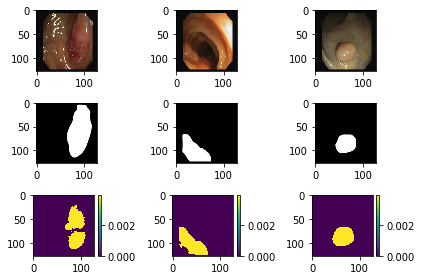

In [60]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[0])
plt.subplot(3,3,2)
imshow(x_test[1])
plt.subplot(3,3,3)
imshow(x_test[2])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[0])
plt.subplot(3,3,5)
imshow(y_test[1])
plt.subplot(3,3,6)
imshow(y_test[2])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred1[0])
plt.subplot(3,3,8)
imshow(y_pred1[1])
plt.subplot(3,3,9)
imshow(y_pred1[2])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

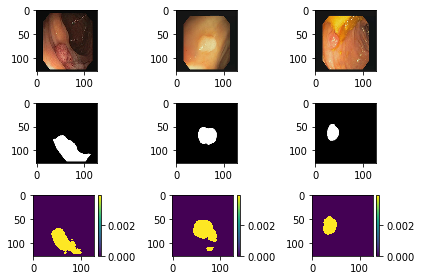

In [61]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[3])
plt.subplot(3,3,2)
imshow(x_test[4])
plt.subplot(3,3,3)
imshow(x_test[5])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[3])
plt.subplot(3,3,5)
imshow(y_test[4])
plt.subplot(3,3,6)
imshow(y_test[5])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred1[3])
plt.subplot(3,3,8)
imshow(y_pred1[4])
plt.subplot(3,3,9)
imshow(y_pred1[5])
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

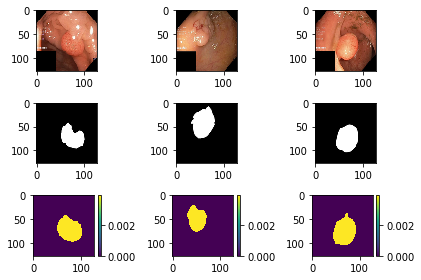

In [62]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[6])
plt.subplot(3,3,2)
imshow(x_test[7])
plt.subplot(3,3,3)
imshow(x_test[8])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[6])
plt.subplot(3,3,5)
imshow(y_test[7])
plt.subplot(3,3,6)
imshow(y_test[8])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred1[6])
plt.subplot(3,3,8)
imshow(y_pred1[7])
plt.subplot(3,3,9)
imshow(y_pred1[8])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

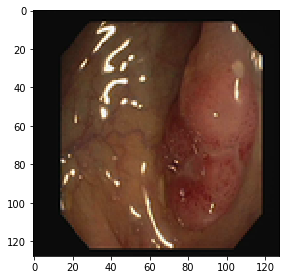

In [131]:
k =0
imshow(x_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

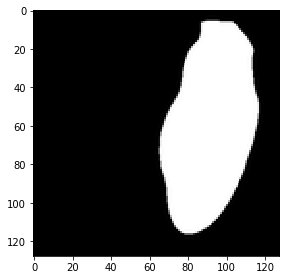

In [132]:
imshow(y_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

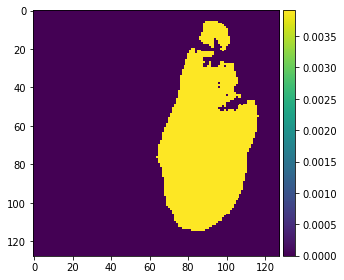

In [133]:
imshow(y_pred1[k])
plt.show

In [63]:
intersection = np.logical_and(y_test, y_pred1)
union = np.logical_or(y_test, y_pred1)
iou_score = np.sum(intersection) / np.sum(union)
print ("IoU socre is: ",iou_score)

IoU socre is:  0.7155225144685456


In [153]:
print("Average test loss: ", np.average(history1.history['loss']))
print("Average test validation jacard: ", np.average(history1.history['val_jacard_coef']))
print("Average test validation jacard: ", np.average(history1.history['val_dice_coef']))
print("Average jacard: ", np.average(history1.history['jacard_coef']))

Average test loss:  0.07083326200023293
Average test validation jacard:  0.5525661528855562
Average test validation jacard:  0.6937304291129113
Average test validation jacard:  0.7111948654055595


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir log_folder1

In [ ]:
# model1.save("./model1.h5")

# SEGNET MODEL 2

In [68]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

input1=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
conv1=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
c1=tf.keras.layers.BatchNormalization()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(c1)
pool1 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

conv1=tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
c2=tf.keras.layers.BatchNormalization()(conv2)
drop2 = tf.keras.layers.Dropout(0.1)(c2)
pool2 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2) 

conv1=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c3=tf.keras.layers.BatchNormalization()(conv3)
drop3 = tf.keras.layers.Dropout(0.1)(c3)
pool3 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3) 

conv1=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c4=tf.keras.layers.BatchNormalization()(conv3)
drop4 = tf.keras.layers.Dropout(0.1)(c4)
pool4 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4) 

conv1=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c5=tf.keras.layers.BatchNormalization()(conv3)
drop5 = tf.keras.layers.Dropout(0.1)(c5)
pool5 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop5) 



up1 =tf.keras.layers.Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(pool5))
merge1 = tf.keras.layers.concatenate([c5,up1], axis =3)

conv1=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up2 =tf.keras.layers.Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge2 = tf.keras.layers.concatenate([c4,up2], axis =3)

conv1=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up3 =tf.keras.layers.Conv2D(64,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge3 = tf.keras.layers.concatenate([c3,up3], axis =3)

conv1=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up4 =tf.keras.layers.Conv2D(32,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge4 = tf.keras.layers.concatenate([c2,up4], axis =3) 

conv1=tf.keras.layers.Conv2D(32,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(32,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
batch2 = tf.keras.layers.Dropout(0.2)(batch2)


up5 =tf.keras.layers.Conv2D(16,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch2))
merge5 = tf.keras.layers.concatenate([c1,up5], axis =3) 

conv1=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)


output=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(batch2)

model2 = tf.keras.Model(inputs=[input1], outputs=[output])
model2.compile(optimizer='adam', loss="binary_crossentropy",metrics=['binary_accuracy',dice_coef,jacard_coef])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 128, 128, 16) 64          conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_26[0][0]     
____________________________________________________________________________________________

In [69]:
log_folder2 = "logs/fit2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [70]:
callbacks2 = tf.keras.callbacks.TensorBoard(
                    log_dir=log_folder2,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    write_steps_per_second=False,
                    update_freq='epoch',
                    profile_batch=0,
                    embeddings_freq=0,
                    embeddings_metadata=None,
                    )


In [71]:
history2 = model2.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100,
                    verbose=1,
                    batch_size = 12,
                    validation_data = (x_val, y_val),
                    callbacks= [callbacks2])
ipd.Audio("https://www.soundjay.com/misc/sounds/censor-beep-3.mp3", rate=10000, autoplay=True)

Epoch 1/100
131/131 [==============================] - 13s 65ms/step - loss: 0.5553 - binary_accuracy: 0.7709 - dice_coef: 0.2387 - jacard_coef: 0.1366 - val_loss: 0.4431 - val_binary_accuracy: 0.8169 - val_dice_coef: 0.2593 - val_jacard_coef: 0.1498
Epoch 2/100
131/131 [==============================] - 8s 61ms/step - loss: 0.3409 - binary_accuracy: 0.8778 - dice_coef: 0.2865 - jacard_coef: 0.1683 - val_loss: 1.2123 - val_binary_accuracy: 0.7777 - val_dice_coef: 0.3647 - val_jacard_coef: 0.2249
Epoch 3/100
131/131 [==============================] - 8s 65ms/step - loss: 0.2517 - binary_accuracy: 0.8937 - dice_coef: 0.3565 - jacard_coef: 0.2182 - val_loss: 0.4461 - val_binary_accuracy: 0.8613 - val_dice_coef: 0.3938 - val_jacard_coef: 0.2478
Epoch 4/100
131/131 [==============================] - 9s 65ms/step - loss: 0.2162 - binary_accuracy: 0.9026 - dice_coef: 0.4203 - jacard_coef: 0.2673 - val_loss: 0.2949 - val_binary_accuracy: 0.8880 - val_dice_coef: 0.5228 - val_jacard_coef: 0.3579

131/131 [==============================] - 9s 67ms/step - loss: 0.0465 - binary_accuracy: 0.9595 - dice_coef: 0.8713 - jacard_coef: 0.7732 - val_loss: 0.1942 - val_binary_accuracy: 0.9182 - val_dice_coef: 0.7090 - val_jacard_coef: 0.5563.0464 - binary_accuracy: 0.9606 - dice_coef: 0.8675 - jaca - ETA: 5s - loss: 0.0484 - binary_accuracy: 0.9595 - dice_coef: 0.8676 - jacard_coef: 0.7 - ETA: 5s - loss: 0.0481 - binary_accuracy: 0.9596 - dice_ - ETA: 3s - loss: 0.0459 - binary_accuracy: 0.9601 
Epoch 31/100
131/131 [==============================] - 9s 67ms/step - loss: 0.0617 - binary_accuracy: 0.9542 - dice_coef: 0.8341 - jacard_coef: 0.7185 - val_loss: 0.1551 - val_binary_accuracy: 0.9367 - val_dice_coef: 0.7712 - val_jacard_coef: 0.6332
Epoch 32/100
131/131 [==============================] - 9s 65ms/step - loss: 0.0435 - binary_accuracy: 0.9605 - dice_coef: 0.8795 - jacard_coef: 0.7862 - val_loss: 0.1859 - val_binary_accuracy: 0.9117 - val_dice_coef: 0.5651 - val_jacard_coef: 0.3992
E

131/131 [==============================] - 9s 67ms/step - loss: 0.0252 - binary_accuracy: 0.9659 - dice_coef: 0.9299 - jacard_coef: 0.8694 - val_loss: 0.1524 - val_binary_accuracy: 0.9408 - val_dice_coef: 0.8150 - val_jacard_coef: 0.6944
Epoch 59/100
131/131 [==============================] - 9s 66ms/step - loss: 0.0308 - binary_accuracy: 0.9640 - dice_coef: 0.9181 - jacard_coef: 0.8498 - val_loss: 0.2000 - val_binary_accuracy: 0.9235 - val_dice_coef: 0.7599 - val_jacard_coef: 0.6170
Epoch 60/100
131/131 [==============================] - 9s 68ms/step - loss: 0.0298 - binary_accuracy: 0.9644 - dice_coef: 0.9173 - jacard_coef: 0.8478 - val_loss: 0.1883 - val_binary_accuracy: 0.9367 - val_dice_coef: 0.7730 - val_jacard_coef: 0.6388
Epoch 61/100
131/131 [==============================] - 8s 65ms/step - loss: 0.0283 - binary_accuracy: 0.9650 - dice_coef: 0.9218 - jacard_coef: 0.8556 - val_loss: 0.1530 - val_binary_accuracy: 0.9415 - val_dice_coef: 0.8197 - val_jacard_coef: 0.7006ef: 0.9223

131/131 [==============================] - 9s 67ms/step - loss: 0.0168 - binary_accuracy: 0.9680 - dice_coef: 0.9525 - jacard_coef: 0.9094 - val_loss: 0.2029 - val_binary_accuracy: 0.9404 - val_dice_coef: 0.8238 - val_jacard_coef: 0.7106.952
Epoch 85/100
131/131 [==============================] - 9s 66ms/step - loss: 0.0193 - binary_accuracy: 0.9674 - dice_coef: 0.9471 - jacard_coef: 0.8997 - val_loss: 0.1879 - val_binary_accuracy: 0.9394 - val_dice_coef: 0.8200 - val_jacard_coef: 0.7021
Epoch 86/100
131/131 [==============================] - 8s 65ms/step - loss: 0.0228 - binary_accuracy: 0.9665 - dice_coef: 0.9381 - jacard_coef: 0.8838 - val_loss: 0.2265 - val_binary_accuracy: 0.9310 - val_dice_coef: 0.7623 - val_jacard_coef: 0.6244
Epoch 87/100
131/131 [==============================] - 9s 66ms/step - loss: 0.0967 - binary_accuracy: 0.9445 - dice_coef: 0.7682 - jacard_coef: 0.6356 - val_loss: 0.2277 - val_binary_accuracy: 0.9289 - val_dice_coef: 0.7301 - val_jacard_coef: 0.5828
Epoch

In [82]:
model21 = K.models.load_model('model2.h5',custom_objects=({ 'dice_coef':'dice_coef','jacard_coef':'jacard_coef' }))

In [83]:
y_pred2 = np.zeros((len(test_list), 128,128,3), dtype=np.uint8)

In [81]:
y_pred2 = model2.predict(np.asarray(x_test))
y_pred2 = (y_pred2 > 0.2).astype(np.uint8)

In [82]:
y_pred2 = y_pred2 / 255.0

<function matplotlib.pyplot.show(close=None, block=None)>

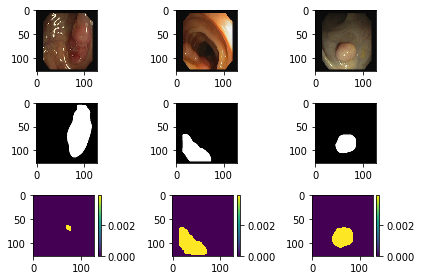

In [137]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[0])
plt.subplot(3,3,2)
imshow(x_test[1])
plt.subplot(3,3,3)
imshow(x_test[2])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[0])
plt.subplot(3,3,5)
imshow(y_test[1])
plt.subplot(3,3,6)
imshow(y_test[2])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred2[0])
plt.subplot(3,3,8)
imshow(y_pred2[1])
plt.subplot(3,3,9)
imshow(y_pred2[2])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

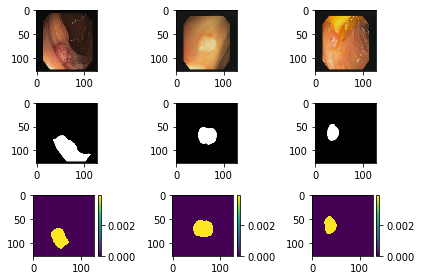

In [138]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[3])
plt.subplot(3,3,2)
imshow(x_test[4])
plt.subplot(3,3,3)
imshow(x_test[5])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[3])
plt.subplot(3,3,5)
imshow(y_test[4])
plt.subplot(3,3,6)
imshow(y_test[5])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred2[3])
plt.subplot(3,3,8)
imshow(y_pred2[4])
plt.subplot(3,3,9)
imshow(y_pred2[5])
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

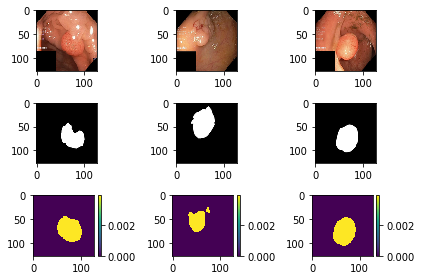

In [139]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[6])
plt.subplot(3,3,2)
imshow(x_test[7])
plt.subplot(3,3,3)
imshow(x_test[8])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[6])
plt.subplot(3,3,5)
imshow(y_test[7])
plt.subplot(3,3,6)
imshow(y_test[8])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred2[6])
plt.subplot(3,3,8)
imshow(y_pred2[7])
plt.subplot(3,3,9)
imshow(y_pred2[8])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

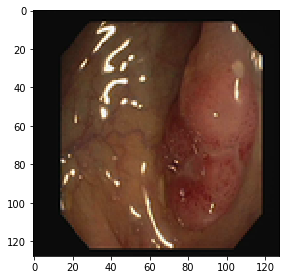

In [89]:
k =0
imshow(x_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

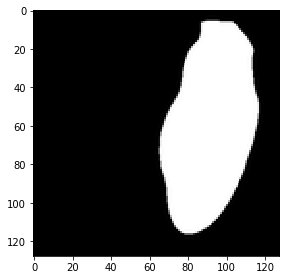

In [90]:
imshow(y_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

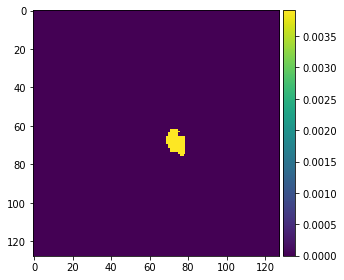

In [91]:
imshow(y_pred2[k])
plt.show

In [140]:
intersection = np.logical_and(y_test, y_pred2)
union = np.logical_or(y_test, y_pred2)
iou_score = np.sum(intersection) / np.sum(union)
print ("IoU socre is: ",iou_score)

IoU socre is:  0.5785355486862442


In [162]:
print("Average test loss: ", np.average(history2.history['loss']))
print("Average val Jacard: ", np.average(history2.history['val_jacard_coef']))
print("Average Jacard: ", np.average(history2.history['jacard_coef']))
print("Average Dice: ", np.average(history2.history['val_dice_coef']))

Average test loss:  0.05608189729973674
Average val Jacard:  0.6106738173216582
Average Jacard:  0.7724300189316273
Average Dice:  0.7433427217602729


In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_folder2

In [ ]:
# model2.save("./model2.h5")

# UNET MODEL 3


In [93]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

#Contraction Path
c11 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(inputs)
c11 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(c11)
p11 = tf.keras.layers.MaxPooling2D((2,2))(c11)
batch11=tf.keras.layers.BatchNormalization()(p11)


c22 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batch11)
c22 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c22)
p22 = tf.keras.layers.MaxPooling2D((2, 2))(c22)
batch22=tf.keras.layers.BatchNormalization()(p22)

 
c33 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(batch22)
c33 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c33)
p33 = tf.keras.layers.MaxPooling2D((2, 2))(c33)
batch33=tf.keras.layers.BatchNormalization()(p33)

 
c44 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(batch33)
c44 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c44)
p44 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c44)
batch44=tf.keras.layers.BatchNormalization()(p44)


 
c55 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(batch44)
c55 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c55)
batch55=tf.keras.layers.BatchNormalization()(c55)



#Expansive path 
u66 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(batch55)
u66 = tf.keras.layers.concatenate([u66, c44])
c66 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u66)
c66 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c66)
batch66=tf.keras.layers.BatchNormalization()(c66)


 
u77 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(batch66)
u77 = tf.keras.layers.concatenate([u77, c33])
c77 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u77)
c77 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c77)
batch77=tf.keras.layers.BatchNormalization()(c77)


 
u88 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(batch77)
u88 = tf.keras.layers.concatenate([u88, c22])
c88 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u88)
c88 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c88)
batch88=tf.keras.layers.BatchNormalization()(c88)


 
u99 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(batch88)
u99 = tf.keras.layers.concatenate([u99, c11], axis=3)
c99 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u99)
c99 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c99)
batch99=tf.keras.layers.BatchNormalization()(c99)


 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(batch99)
 
model3 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model3.compile(optimizer='adam', loss="binary_crossentropy",metrics=['binary_accuracy',dice_coef,jacard_coef])
model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_70[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_71[0][0]                  
____________________________________________________________________________________________

In [94]:
log_folder3 = "logs/fit3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [95]:
callbacks3 = tf.keras.callbacks.TensorBoard(
                    log_dir=log_folder3,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    write_steps_per_second=False,
                    update_freq='epoch',
                    profile_batch=0,
                    embeddings_freq=0,
                    embeddings_metadata=None,
                    )


In [96]:
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='loss')
history3 = model3.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100,
                    verbose=1,
                    batch_size = 12,
                    validation_data = (x_val, y_val),
                    callbacks= [callbacks3])
ipd.Audio("https://www.soundjay.com/misc/sounds/censor-beep-3.mp3", rate=10000, autoplay=True)

Epoch 1/100
131/131 [==============================] - 7s 39ms/step - loss: 0.6131 - binary_accuracy: 0.8080 - dice_coef: 0.2392 - jacard_coef: 0.1370 - val_loss: 0.5140 - val_binary_accuracy: 0.8716 - val_dice_coef: 0.1945 - val_jacard_coef: 0.1082
Epoch 2/100
131/131 [==============================] - 5s 35ms/step - loss: 0.4299 - binary_accuracy: 0.8820 - dice_coef: 0.2955 - jacard_coef: 0.1745 - val_loss: 0.4011 - val_binary_accuracy: 0.8825 - val_dice_coef: 0.2431 - val_jacard_coef: 0.1390
Epoch 3/100
131/131 [==============================] - 5s 34ms/step - loss: 0.3353 - binary_accuracy: 0.9027 - dice_coef: 0.3845 - jacard_coef: 0.2394 - val_loss: 0.3862 - val_binary_accuracy: 0.8816 - val_dice_coef: 0.2133 - val_jacard_coef: 0.1204
Epoch 4/100
131/131 [==============================] - 5s 35ms/step - loss: 0.2829 - binary_accuracy: 0.9156 - dice_coef: 0.4730 - jacard_coef: 0.3115 - val_loss: 0.3480 - val_binary_accuracy: 0.8938 - val_dice_coef: 0.3322 - val_jacard_coef: 0.2020


131/131 [==============================] - 5s 36ms/step - loss: 0.0343 - binary_accuracy: 0.9683 - dice_coef: 0.9374 - jacard_coef: 0.8823 - val_loss: 0.1763 - val_binary_accuracy: 0.9386 - val_dice_coef: 0.7944 - val_jacard_coef: 0.6669
Epoch 55/100
131/131 [==============================] - 5s 36ms/step - loss: 0.0329 - binary_accuracy: 0.9685 - dice_coef: 0.9404 - jacard_coef: 0.8877 - val_loss: 0.1728 - val_binary_accuracy: 0.9395 - val_dice_coef: 0.8031 - val_jacard_coef: 0.6785s: 0.0324 - binary_accuracy: 0.9691 - dice_c
Epoch 56/100
131/131 [==============================] - 5s 36ms/step - loss: 0.0322 - binary_accuracy: 0.9687 - dice_coef: 0.9426 - jacard_coef: 0.8916 - val_loss: 0.1757 - val_binary_accuracy: 0.9391 - val_dice_coef: 0.8005 - val_jacard_coef: 0.6755_accuracy: 0.9684 - dice_co
Epoch 57/100
131/131 [==============================] - 5s 37ms/step - loss: 0.0319 - binary_accuracy: 0.9688 - dice_coef: 0.9430 - jacard_coef: 0.8923 - val_loss: 0.1751 - val_binary_accur

In [105]:
x_test.shape

(9, 128, 128, 3)

In [113]:
model31 = K.models.load_model('model3.h5',custom_objects=({ 'dice_coef':'dice_coef','jacard_coef':'jacard_coef' }))

In [121]:
y_pred3 = model3.predict(np.asarray(x_test))
y_pred3 = (y_pred3 > 0.4).astype(np.uint8)

In [122]:
y_pred3 = y_pred3 / 255.0

<function matplotlib.pyplot.show(close=None, block=None)>

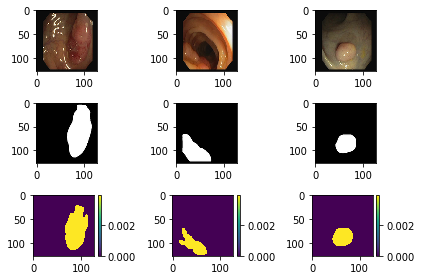

In [123]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[0])
plt.subplot(3,3,2)
imshow(x_test[1])
plt.subplot(3,3,3)
imshow(x_test[2])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[0])
plt.subplot(3,3,5)
imshow(y_test[1])
plt.subplot(3,3,6)
imshow(y_test[2])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred3[0])
plt.subplot(3,3,8)
imshow(y_pred3[1])
plt.subplot(3,3,9)
imshow(y_pred3[2])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

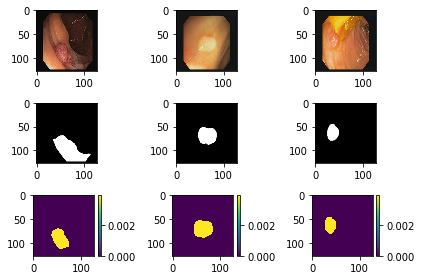

In [118]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[3])
plt.subplot(3,3,2)
imshow(x_test[4])
plt.subplot(3,3,3)
imshow(x_test[5])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[3])
plt.subplot(3,3,5)
imshow(y_test[4])
plt.subplot(3,3,6)
imshow(y_test[5])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred3[3])
plt.subplot(3,3,8)
imshow(y_pred3[4])
plt.subplot(3,3,9)
imshow(y_pred3[5])
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

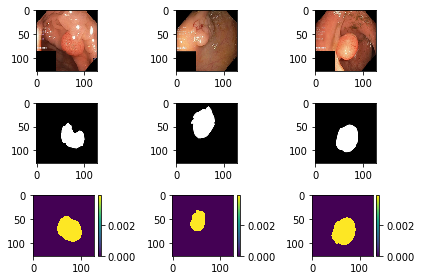

In [119]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[6])
plt.subplot(3,3,2)
imshow(x_test[7])
plt.subplot(3,3,3)
imshow(x_test[8])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[6])
plt.subplot(3,3,5)
imshow(y_test[7])
plt.subplot(3,3,6)
imshow(y_test[8])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred3[6])
plt.subplot(3,3,8)
imshow(y_pred3[7])
plt.subplot(3,3,9)
imshow(y_pred3[8])
plt.show 


In [ ]:
k =0
imshow(x_test[k])
plt.show

In [ ]:
imshow(y_test[k])
plt.show

In [ ]:
imshow(y_pred3[k])
plt.show

In [124]:
intersection = np.logical_and(y_test, y_pred3)
union = np.logical_or(y_test, y_pred3)
iou_score = np.sum(intersection) / np.sum(union)
print ("IoU socre is: ",iou_score)

IoU socre is:  0.702488962204648


In [161]:
print("Average test loss: ", np.average(history3.history['loss']))
print("Average test validation jacard coeff: ", np.average(history3.history['val_jacard_coef']))
print("Average test jacard coeff: ", np.average(history3.history['jacard_coef']))
print("Average test validation Dice: ", np.average(history3.history['dice_coef']))

Average test loss:  0.06977688778191805
Average test validation jacard coeff:  0.6019505076855421
Average test jacard coeff:  0.7933725212514401
Average test validation Dice:  0.8715192753076554


In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_folder3

In [ ]:
# model3.save("./model3.h5")

# MODEL 4 


In [149]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

#Contraction Path
c11 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(inputs)
c11 = tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(c11)
p11 = tf.keras.layers.MaxPooling2D((2,2))(c11)
batch11=tf.keras.layers.BatchNormalization()(p11)
batch11 = tf.keras.layers.Dropout(0.1)(batch11)


c22 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(batch11)
c22 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c22)
p22 = tf.keras.layers.MaxPooling2D((2, 2))(c22)
batch22=tf.keras.layers.BatchNormalization()(p22)

 
c33 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(batch22)
c33 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c33)
p33 = tf.keras.layers.MaxPooling2D((2, 2))(c33)
batch33=tf.keras.layers.BatchNormalization()(p33)
batch33 = tf.keras.layers.Dropout(0.1)(batch33)
 
c44 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(batch33)
c44 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c44)
p44 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c44)
batch44=tf.keras.layers.BatchNormalization()(p44)


 
c55 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(batch44)
c55 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c55)
batch55=tf.keras.layers.BatchNormalization()(c55)
batch55 = tf.keras.layers.Dropout(0.1)(batch55)



#Expansive path 
u66 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(batch55)
u66 = tf.keras.layers.concatenate([u66, c44])

c66 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u66)
c66 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c66)
batch66=tf.keras.layers.BatchNormalization()(c66)


 
u77 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(batch66)
u77 = tf.keras.layers.concatenate([u77, c33])
c77 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u77)
c77 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c77)
batch77=tf.keras.layers.BatchNormalization()(c77)
batch77 = tf.keras.layers.Dropout(0.1)(batch77)


 
u88 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(batch77)
u88 = tf.keras.layers.concatenate([u88, c22])
c88 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u88)
c88 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c88)
batch88=tf.keras.layers.BatchNormalization()(c88)


 
u99 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(batch88)
u99 = tf.keras.layers.concatenate([u99, c11], axis=3)
c99 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u99)
c99 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c99)
batch99=tf.keras.layers.BatchNormalization()(c99)
batch99 = tf.keras.layers.Dropout(0.1)(batch99)


 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01))(batch99)
 
model4 = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model4.compile(optimizer='adam', loss="binary_crossentropy",metrics=['binary_accuracy',dice_coef,jacard_coef])
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 128, 128, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_89[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_90[0][0]                  
____________________________________________________________________________________________

In [150]:
log_folder4 = "logs/fit4/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [151]:
callbacks4 = tf.keras.callbacks.TensorBoard(
                    log_dir=log_folder4,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    write_steps_per_second=False,
                    update_freq='epoch',
                    profile_batch=0,
                    embeddings_freq=0,
                    embeddings_metadata=None,
                    )


In [152]:
history4 = model4.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100,
                    verbose=1,
                    batch_size = 12,
                    validation_data = (x_val, y_val),
                    callbacks= [callbacks4])
ipd.Audio("https://www.soundjay.com/misc/sounds/censor-beep-3.mp3", rate=10000, autoplay=True)

Epoch 1/100
131/131 [==============================] - 7s 39ms/step - loss: 0.6259 - binary_accuracy: 0.7782 - dice_coef: 0.2204 - jacard_coef: 0.1249 - val_loss: 0.7254 - val_binary_accuracy: 0.6718 - val_dice_coef: 0.2427 - val_jacard_coef: 0.1389
Epoch 2/100
131/131 [==============================] - 5s 36ms/step - loss: 0.4391 - binary_accuracy: 0.8803 - dice_coef: 0.2793 - jacard_coef: 0.1635 - val_loss: 0.6249 - val_binary_accuracy: 0.8125 - val_dice_coef: 0.3339 - val_jacard_coef: 0.2014
Epoch 3/100
131/131 [==============================] - 5s 35ms/step - loss: 0.3480 - binary_accuracy: 0.8959 - dice_coef: 0.3506 - jacard_coef: 0.2137 - val_loss: 0.3784 - val_binary_accuracy: 0.8896 - val_dice_coef: 0.3268 - val_jacard_coef: 0.1971
Epoch 4/100
131/131 [==============================] - 4s 34ms/step - loss: 0.3038 - binary_accuracy: 0.9052 - dice_coef: 0.4137 - jacard_coef: 0.2621 - val_loss: 0.3724 - val_binary_accuracy: 0.8613 - val_dice_coef: 0.4587 - val_jacard_coef: 0.3003


131/131 [==============================] - 5s 38ms/step - loss: 0.0448 - binary_accuracy: 0.9654 - dice_coef: 0.9073 - jacard_coef: 0.8312 - val_loss: 0.1834 - val_binary_accuracy: 0.9341 - val_dice_coef: 0.7545 - val_jacard_coef: 0.6155
Epoch 59/100
131/131 [==============================] - 5s 39ms/step - loss: 0.0387 - binary_accuracy: 0.9670 - dice_coef: 0.9233 - jacard_coef: 0.8580 - val_loss: 0.1950 - val_binary_accuracy: 0.9313 - val_dice_coef: 0.7490 - val_jacard_coef: 0.6083binary_accuracy: 0.9671 - dice_coef: 0.9234 - jacard_coef: 0.85
Epoch 60/100
131/131 [==============================] - 5s 39ms/step - loss: 0.0553 - binary_accuracy: 0.9614 - dice_coef: 0.8780 - jacard_coef: 0.7848 - val_loss: 0.1725 - val_binary_accuracy: 0.9334 - val_dice_coef: 0.7767 - val_jacard_coef: 0.6417s: 0.0606 - binary_accuracy: 0.9599 - dice_coef: 
Epoch 61/100
131/131 [==============================] - 5s 39ms/step - loss: 0.0392 - binary_accuracy: 0.9667 - dice_coef: 0.9209 - jacard_coef: 0.8

Epoch 87/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0498 - binary_accuracy: 0.9619 - dice_coef: 0.8866 - jacard_coef: 0.7985 - val_loss: 0.1750 - val_binary_accuracy: 0.9339 - val_dice_coef: 0.7650 - val_jacard_coef: 0.6278
Epoch 88/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0385 - binary_accuracy: 0.9655 - dice_coef: 0.9180 - jacard_coef: 0.8493 - val_loss: 0.2141 - val_binary_accuracy: 0.9284 - val_dice_coef: 0.7232 - val_jacard_coef: 0.5759ss: 0.0386 - binary_accuracy: 0.9661 - dice
Epoch 89/100
131/131 [==============================] - 5s 39ms/step - loss: 0.0335 - binary_accuracy: 0.9668 - dice_coef: 0.9295 - jacard_coef: 0.8687 - val_loss: 0.1785 - val_binary_accuracy: 0.9350 - val_dice_coef: 0.7680 - val_jacard_coef: 0.6306
Epoch 90/100
131/131 [==============================] - 5s 42ms/step - loss: 0.0342 - binary_accuracy: 0.9667 - dice_coef: 0.9295 - jacard_coef: 0.8692 - val_loss: 0.1775 - val_binary_accuracy: 0.9350 - v

In [141]:
model41 = K.models.load_model('model3.h5',custom_objects=({ 'dice_coef':'dice_coef','jacard_coef':'jacard_coef' }))

In [155]:
y_pred4 = model4.predict(np.asarray(x_test))
y_pred4 = (y_pred4 > 0.4).astype(np.uint8)

In [156]:
y_pred4 = y_pred4 / 255.0

<function matplotlib.pyplot.show(close=None, block=None)>

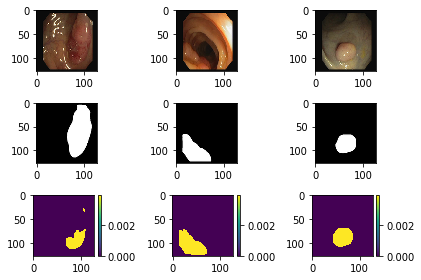

In [157]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[0])
plt.subplot(3,3,2)
imshow(x_test[1])
plt.subplot(3,3,3)
imshow(x_test[2])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[0])
plt.subplot(3,3,5)
imshow(y_test[1])
plt.subplot(3,3,6)
imshow(y_test[2])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred4[0])
plt.subplot(3,3,8)
imshow(y_pred4[1])
plt.subplot(3,3,9)
imshow(y_pred4[2])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

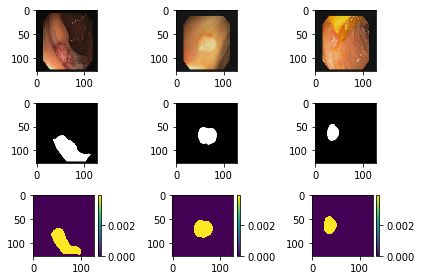

In [158]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[3])
plt.subplot(3,3,2)
imshow(x_test[4])
plt.subplot(3,3,3)
imshow(x_test[5])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[3])
plt.subplot(3,3,5)
imshow(y_test[4])
plt.subplot(3,3,6)
imshow(y_test[5])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred4[3])
plt.subplot(3,3,8)
imshow(y_pred4[4])
plt.subplot(3,3,9)
imshow(y_pred4[5])
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

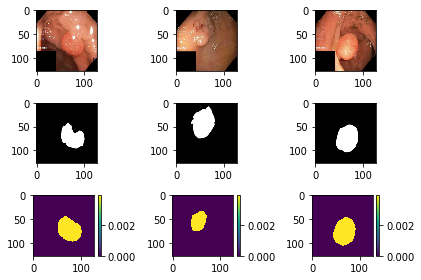

In [159]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[6])
plt.subplot(3,3,2)
imshow(x_test[7])
plt.subplot(3,3,3)
imshow(x_test[8])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[6])
plt.subplot(3,3,5)
imshow(y_test[7])
plt.subplot(3,3,6)
imshow(y_test[8])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred4[6])
plt.subplot(3,3,8)
imshow(y_pred4[7])
plt.subplot(3,3,9)
imshow(y_pred4[8])
plt.show 


In [ ]:
k =0
imshow(x_test[k])
plt.show

In [ ]:
imshow(y_test[k])
plt.show

In [ ]:
imshow(y_pred4[k])
plt.show

In [164]:
intersection = np.logical_and(y_test, y_pred4)
union = np.logical_or(y_test, y_pred4)
iou_score = np.sum(intersection) / np.sum(union)
print ("IoU socre is: ",iou_score)

IoU socre is:  0.6394169835234474


In [154]:
print("Average test loss: ", np.average(history4.history['loss']))
print("Average test validation jacard coeff: ", np.average(history4.history['val_jacard_coef']))
print("Average jacard coeff: ", np.average(history4.history['jacard_coef']))
print("Average test validation dice coeff: ", np.average(history4.history['dice_coef']))

Average test loss:  0.07693174291402101
Average test validation jacard coeff:  0.5805628144741058
Average jacard coeff:  0.7658758258074522
Average test validation dice coeff:  0.852056157886982


In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_folder4

In [ ]:
# model4.save("./model4.h5")

# SEXY MODEL 5


In [64]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

input1=tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
conv1=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
c1=tf.keras.layers.BatchNormalization()(conv2)
drop1 = tf.keras.layers.Dropout(0.1)(c1)
pool1 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

conv1=tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(32,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
c2=tf.keras.layers.BatchNormalization()(conv2)
# drop2 = tf.keras.layers.Dropout(0.1)(c2)
pool2 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c2) 

conv1=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c3=tf.keras.layers.BatchNormalization()(conv3)
drop3 = tf.keras.layers.Dropout(0.1)(c3)
pool3 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3) 

conv1=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c4=tf.keras.layers.BatchNormalization()(conv3)
# drop4 = tf.keras.layers.Dropout(0.1)(c4)
pool4 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4) 

conv1=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
c5=tf.keras.layers.BatchNormalization()(conv3)
drop5 = tf.keras.layers.Dropout(0.1)(c5)
pool5 =tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop5) 



up1 =tf.keras.layers.Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(pool5))
merge1 = tf.keras.layers.concatenate([c5,up1], axis =3)

conv1=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
# batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up2 =tf.keras.layers.Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge2 = tf.keras.layers.concatenate([c4,up2], axis =3)

conv1=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up3 =tf.keras.layers.Conv2D(64,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge3 = tf.keras.layers.concatenate([c3,up3], axis =3)

conv1=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
conv3=tf.keras.layers.Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
batch3=tf.keras.layers.BatchNormalization()(conv3)
# batch3 = tf.keras.layers.Dropout(0.2)(batch3)


up4 =tf.keras.layers.Conv2D(32,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch3))
merge4 = tf.keras.layers.concatenate([c2,up4], axis =3) 

conv1=tf.keras.layers.Conv2D(32,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(32,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)
batch2 = tf.keras.layers.Dropout(0.2)(batch2)


up5 =tf.keras.layers.Conv2D(16,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(batch2))
merge5 = tf.keras.layers.concatenate([c1,up5], axis =3) 

conv1=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
batch1=tf.keras.layers.BatchNormalization()(conv1)
conv2=tf.keras.layers.Conv2D(16,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
batch2=tf.keras.layers.BatchNormalization()(conv2)


output=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(batch2)

model5 = tf.keras.Model(inputs=[input1], outputs=[output])
model5.compile(optimizer='adam', loss="binary_crossentropy",metrics=['binary_accuracy',dice_coef,jacard_coef])
model5.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [65]:
log_folder5 = "logs/fit5/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [66]:
callbacks5 = tf.keras.callbacks.TensorBoard(
                    log_dir=log_folder5,
                    histogram_freq=1,
                    write_graph=True,
                    write_images=True,
                    write_steps_per_second=False,
                    update_freq='epoch',
                    profile_batch=0,
                    embeddings_freq=0,
                    embeddings_metadata=None,
                    )


In [67]:
history5 = model5.fit(x = x_train, 
                    y = y_train, 
                    epochs = 100,
                    verbose=1,
                    batch_size = 8,
                    validation_data = (x_val, y_val),
                    callbacks= [callbacks5])
ipd.Audio("https://www.soundjay.com/misc/sounds/censor-beep-3.mp3", rate=10000, autoplay=True)

Epoch 1/100
196/196 [==============================] - 14s 54ms/step - loss: 0.5073 - binary_accuracy: 0.7948 - dice_coef: 0.2326 - jacard_coef: 0.1329 - val_loss: 1.1884 - val_binary_accuracy: 0.7038 - val_dice_coef: 0.2839 - val_jacard_coef: 0.1676
Epoch 2/100
196/196 [==============================] - 8s 43ms/step - loss: 0.2891 - binary_accuracy: 0.8831 - dice_coef: 0.3001 - jacard_coef: 0.1783 - val_loss: 0.6875 - val_binary_accuracy: 0.8193 - val_dice_coef: 0.3981 - val_jacard_coef: 0.2533
Epoch 3/100
196/196 [==============================] - 8s 43ms/step - loss: 0.2263 - binary_accuracy: 0.8988 - dice_coef: 0.3954 - jacard_coef: 0.2482 - val_loss: 0.2412 - val_binary_accuracy: 0.8921 - val_dice_coef: 0.4673 - val_jacard_coef: 0.3092
Epoch 4/100
196/196 [==============================] - 8s 43ms/step - loss: 0.1999 - binary_accuracy: 0.9078 - dice_coef: 0.4621 - jacard_coef: 0.3028 - val_loss: 0.5114 - val_binary_accuracy: 0.8376 - val_dice_coef: 0.5073 - val_jacard_coef: 0.3457

196/196 [==============================] - 9s 46ms/step - loss: 0.0517 - binary_accuracy: 0.9574 - dice_coef: 0.8618 - jacard_coef: 0.7595 - val_loss: 0.1331 - val_binary_accuracy: 0.9333 - val_dice_coef: 0.7513 - val_jacard_coef: 0.6095
Epoch 34/100
196/196 [==============================] - 9s 48ms/step - loss: 0.0390 - binary_accuracy: 0.9619 - dice_coef: 0.8906 - jacard_coef: 0.8040 - val_loss: 0.1292 - val_binary_accuracy: 0.9390 - val_dice_coef: 0.7649 - val_jacard_coef: 0.6283
Epoch 35/100
196/196 [==============================] - 9s 48ms/step - loss: 0.0348 - binary_accuracy: 0.9631 - dice_coef: 0.9022 - jacard_coef: 0.8228 - val_loss: 0.1370 - val_binary_accuracy: 0.9391 - val_dice_coef: 0.7922 - val_jacard_coef: 0.6651
Epoch 36/100
196/196 [==============================] - 9s 48ms/step - loss: 0.0315 - binary_accuracy: 0.9642 - dice_coef: 0.9113 - jacard_coef: 0.8378 - val_loss: 0.1971 - val_binary_accuracy: 0.9342 - val_dice_coef: 0.7541 - val_jacard_coef: 0.6187
Epoch 37/

Epoch 66/100
196/196 [==============================] - 10s 49ms/step - loss: 0.0335 - binary_accuracy: 0.9632 - dice_coef: 0.9108 - jacard_coef: 0.8399 - val_loss: 0.2333 - val_binary_accuracy: 0.9194 - val_dice_coef: 0.6752 - val_jacard_coef: 0.519147 - dice_coef: 0.9255
Epoch 67/100
196/196 [==============================] - 9s 47ms/step - loss: 0.0541 - binary_accuracy: 0.9567 - dice_coef: 0.8567 - jacard_coef: 0.7542 - val_loss: 0.1601 - val_binary_accuracy: 0.9296 - val_dice_coef: 0.7575 - val_jacard_coef: 0.6169
Epoch 68/100
196/196 [==============================] - 9s 49ms/step - loss: 0.0437 - binary_accuracy: 0.9596 - dice_coef: 0.8790 - jacard_coef: 0.7881 - val_loss: 0.1723 - val_binary_accuracy: 0.9316 - val_dice_coef: 0.7507 - val_jacard_coef: 0.6144
Epoch 69/100
196/196 [==============================] - 10s 49ms/step - loss: 0.0319 - binary_accuracy: 0.9637 - dice_coef: 0.9113 - jacard_coef: 0.8380 - val_loss: 0.1357 - val_binary_accuracy: 0.9399 - val_dice_coef: 0.796

196/196 [==============================] - 10s 51ms/step - loss: 0.0155 - binary_accuracy: 0.9683 - dice_coef: 0.9547 - jacard_coef: 0.9134 - val_loss: 0.1836 - val_binary_accuracy: 0.9421 - val_dice_coef: 0.8283 - val_jacard_coef: 0.7165
Epoch 99/100
196/196 [==============================] - 10s 51ms/step - loss: 0.0152 - binary_accuracy: 0.9684 - dice_coef: 0.9556 - jacard_coef: 0.9152 - val_loss: 0.1912 - val_binary_accuracy: 0.9424 - val_dice_coef: 0.8292 - val_jacard_coef: 0.7180
Epoch 100/100
196/196 [==============================] - 10s 52ms/step - loss: 0.0158 - binary_accuracy: 0.9683 - dice_coef: 0.9545 - jacard_coef: 0.9131 - val_loss: 0.1879 - val_binary_accuracy: 0.9432 - val_dice_coef: 0.8334 - val_jacard_coef: 0.7236ice_coef: 0.9538 - ja - ETA: 2s - loss: 0.0158 - binary_accuracy: 0.9683 - dice_coef: 0.


In [172]:
y_pred5 = np.zeros((len(test_list), 128,128,3), dtype=np.uint8)

In [32]:
model51 = K.models.load_model('bestyet.h5',custom_objects=({ 'dice_coef':'dice_coef','jacard_coef':'jacard_coef' }))

In [94]:
y_pred5 = model5.predict(np.asarray(x_test))
y_pred5 = (y_pred5 > 0.2).astype(np.uint8)

In [95]:
y_pred5 = y_pred5 / 255.0

<function matplotlib.pyplot.show(close=None, block=None)>

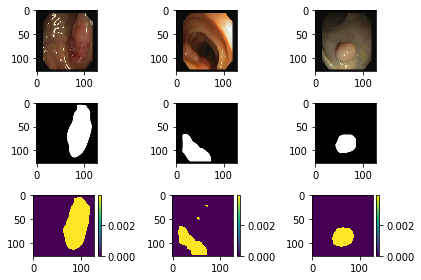

In [96]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[0])
plt.subplot(3,3,2)
imshow(x_test[1])
plt.subplot(3,3,3)
imshow(x_test[2])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[0])
plt.subplot(3,3,5)
imshow(y_test[1])
plt.subplot(3,3,6)
imshow(y_test[2])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred5[0])
plt.subplot(3,3,8)
imshow(y_pred5[1])
plt.subplot(3,3,9)
imshow(y_pred5[2])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

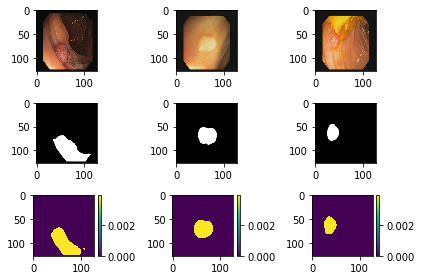

In [97]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[3])
plt.subplot(3,3,2)
imshow(x_test[4])
plt.subplot(3,3,3)
imshow(x_test[5])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[3])
plt.subplot(3,3,5)
imshow(y_test[4])
plt.subplot(3,3,6)
imshow(y_test[5])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred5[3])
plt.subplot(3,3,8)
imshow(y_pred5[4])
plt.subplot(3,3,9)
imshow(y_pred5[5])
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

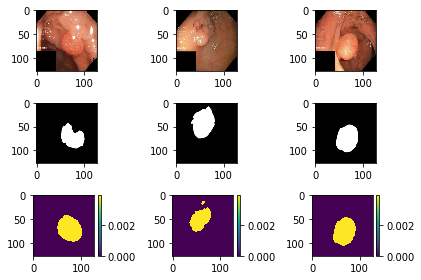

In [98]:
#Test image
plt.subplot(3,3,1)
imshow(x_test[6])
plt.subplot(3,3,2)
imshow(x_test[7])
plt.subplot(3,3,3)
imshow(x_test[8])
plt.show    

#GRound Truth
plt.subplot(3,3,4)
imshow(y_test[6])
plt.subplot(3,3,5)
imshow(y_test[7])
plt.subplot(3,3,6)
imshow(y_test[8])
plt.show 

#Prediction test
plt.subplot(3,3,7)
imshow(y_pred5[6])
plt.subplot(3,3,8)
imshow(y_pred5[7])
plt.subplot(3,3,9)
imshow(y_pred5[8])
plt.show 


<function matplotlib.pyplot.show(close=None, block=None)>

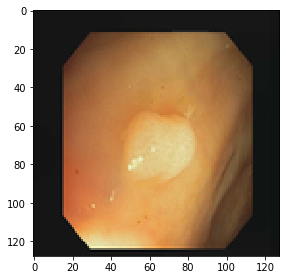

In [50]:
k =4

imshow(x_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

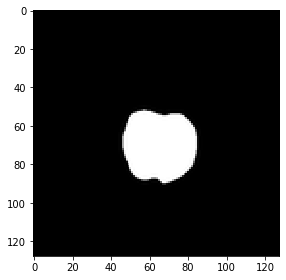

In [51]:
imshow(y_test[k])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

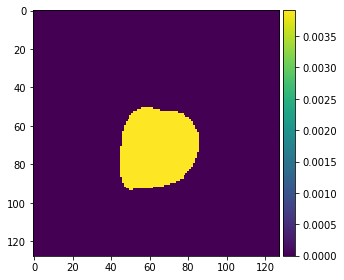

In [52]:
imshow(y_pred5[k])
plt.show

In [40]:
intersection = np.logical_and(y_test, y_pred5)
union = np.logical_or(y_test, y_pred5)
iou_score = np.sum(intersection) / np.sum(union)
print ("IoU socre is: ",iou_score)

IoU socre is:  0.7958115183246073


In [99]:
print("Average test loss: ", np.average(history5.history['loss']))
print("Average DIce : ", np.average(history5.history['dice_coef']))
print("Average Jacard loss: ", np.average(history5.history['val_jacard_coef']))

Average test loss:  0.05551464241929352


In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_folder5

In [42]:
# model5.save("./model5.h5")

In [185]:
# model_json = model51.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
